# Chotagrad

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class Tensor:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.label = label
        self.grad = 0.0
        self._prev = set(_children)
        self._backward = lambda: None
        self._op = _op
        
    def __repr__(self):
        return f"Tensor({self.data})"
    
    # f = x + y
    # df/dy = 1 + 0 
    # df/dx = 0 + 1
    def __add__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)
        out = Tensor(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        return out
    
    # f = x*y
    # df/dx = x*0 + y = 0 + y
    # df/dy = x + y*0 = x + 0 
    def __mul__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)
        out = Tensor(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other): # other + self
        return self + other
    
    def __rmul__(self, other): # other * self
        return self * other
    
    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), 'only supporting int/float' 
        out = Tensor(self.data**other, (self,), label=f'**{other}')
        
        def _backward():
            self.grad += other * (self.data**(other-1)) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Tensor(np.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    # tanh(x) = (e^x - e^-x / e^x + e^-x) = (e^2x - 1 / e^2x + 1)
    # dtanh(x)/dx = 1 - tanh(x)**2
    def tanh(self):
        x = self.data
        t = (np.exp(2*x) - 1) / (np.exp(2*x) + 1)
        out = Tensor(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out 
        
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [4]:
i = Tensor(2.0, label='i')
i

Tensor(2.0)

In [5]:
i**2

Tensor(4.0)

In [6]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label='{%s | data %.4f | grad %.4f}'%(n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid+n._op, label=n._op)
            dot.edge(uid+n._op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [7]:
a = Tensor(1.0, label='a')
b = Tensor(2.0, label='b')
c = Tensor(-4.0, label='c')

In [8]:
a - 1

Tensor(0.0)

In [9]:
a, b, c

(Tensor(1.0), Tensor(2.0), Tensor(-4.0))

In [10]:
d = a + b; d

Tensor(3.0)

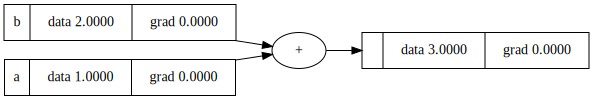

In [11]:
draw_dot(d)

In [12]:
e = d * c; e

Tensor(-12.0)

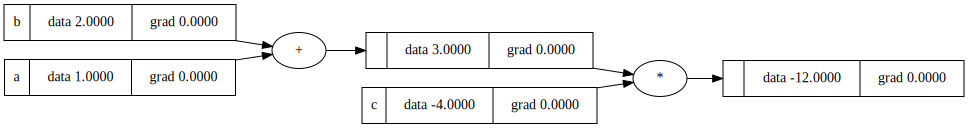

In [13]:
draw_dot(e)

In [14]:
d.backward(); d.grad

1.0

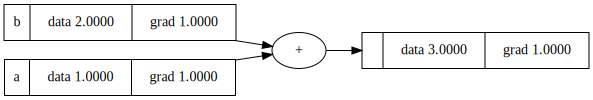

In [15]:
draw_dot(d)

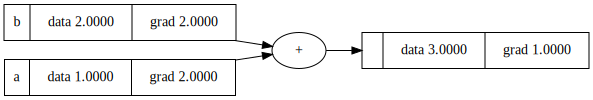

In [16]:
d.grad = 1.0
d._backward(); draw_dot(d)

In [17]:
e.backward(); e.grad

1.0

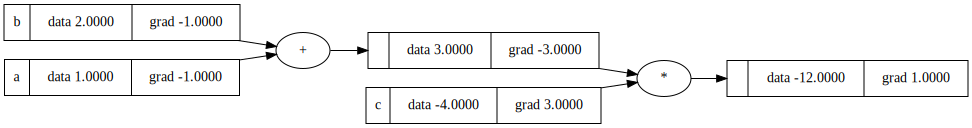

In [18]:
draw_dot(e)

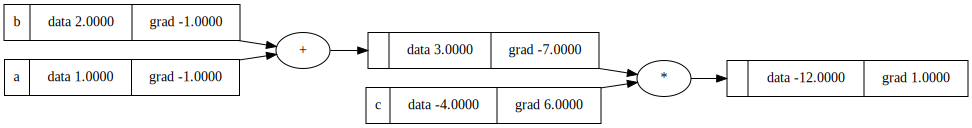

In [19]:
e.grad = 1.0
e._backward(); draw_dot(e)

In [20]:
a.tanh().data

0.7615941559557649

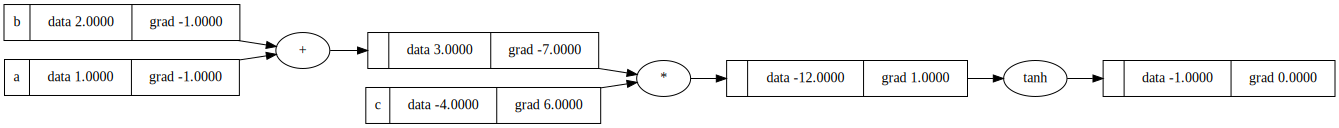

In [21]:
f = e.tanh(); draw_dot(f)

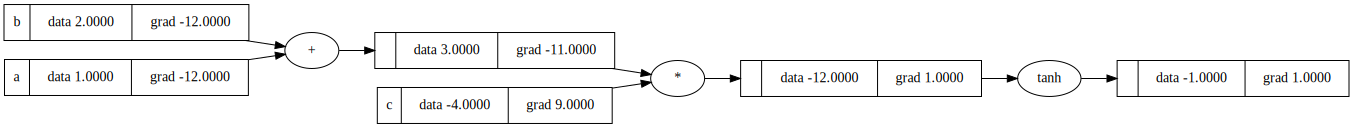

In [22]:
f.backward(); draw_dot(f)

In [23]:
a.tanh().grad

0.0

In [24]:
import torch
at = torch.Tensor([1.0])
bt = torch.Tensor([2.0])
ct = torch.Tensor([-4.0])

In [25]:
at.tanh().data[0]

tensor(0.7616)

In [26]:
at.tanh(); at.requires_grad = True

In [27]:
torch.isclose(at.tanh(), torch.Tensor([a.tanh().data]))

tensor([True])

In [28]:
import random
random.random() * 10

3.78367640446028

In [29]:
x1 = Tensor(0.0, label='x1')
x2 = Tensor(2.0, label='x1')

w1 = Tensor(1.0, label='w1')
w2 = Tensor(-2.0, label='w2')

b = Tensor(4.942069420, label='b')

x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'

n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'

In [30]:
np.tanh(n)

Tensor(0.7361715985212502)

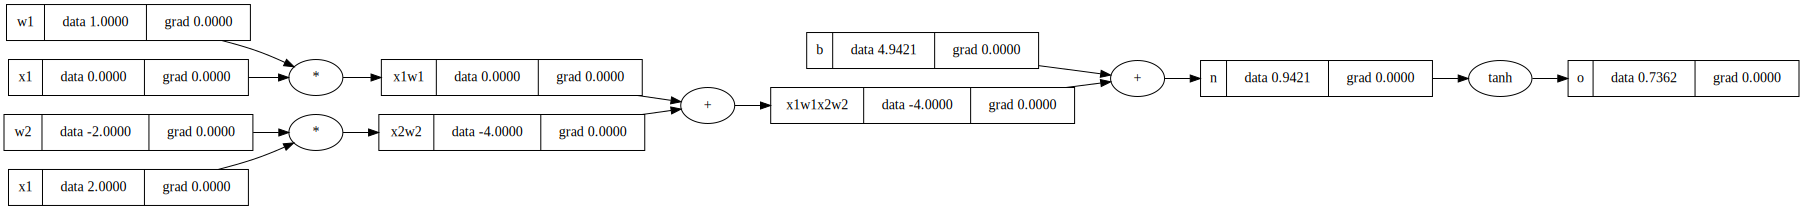

In [31]:
draw_dot(o)

In [32]:
o.backward()

In [33]:
o

Tensor(0.7361715985212502)

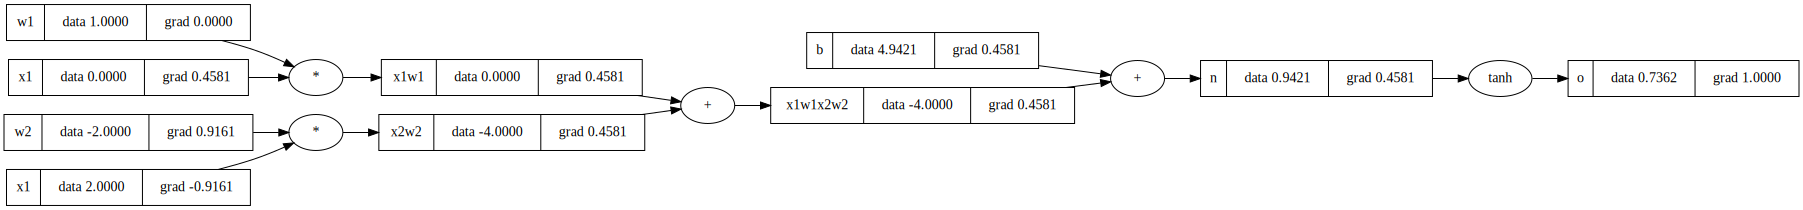

In [34]:
draw_dot(o)

$tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}} = \frac{1 - e^{-2x}}{1 + e^{2x}}$

In [35]:
(e - 1) / (e + 1)

Tensor(1.1818181818181819)

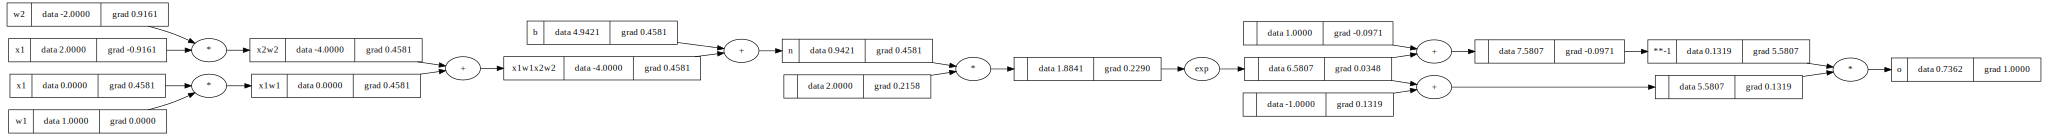

In [36]:
x1 = Tensor(0.0, label='x1')
x2 = Tensor(2.0, label='x1')

w1 = Tensor(1.0, label='w1')
w2 = Tensor(-2.0, label='w2')

b = Tensor(4.942069420, label='b')

x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'

n = x1w1x2w2 + b; n.label='n'
e = (2*n).exp()
o = (e-1) / (e+1); o.label = 'o'
o.backward()
draw_dot(o)

In [85]:
class Neuron:
    def __init__(self, nin):
        self.w = [Tensor(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Tensor(random.uniform(-1, 1))
        
    def __call__(self, x):
        act = sum((wi*xi for xi, wi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def params(self):
        return self.w + [self.b]

In [86]:
x = [2.0, 3.0]
n = Neuron(2)
n(x)

Tensor(0.7089116795695986)

In [87]:
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    
    def params(self):
        return [p for neuron in self.neurons for p in neuron.params()]

In [88]:
x = [2.0, 3.0]
l = Layer(2, 3)
l(x)

[Tensor(0.5362261725137623),
 Tensor(0.7166655393097897),
 Tensor(0.8284090522197817)]

In [89]:
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def params(self):
        return [p for layer in self.layers for p in layer.params()]

In [90]:
x = [2.0, 3.0, -6.0]
n = MLP(3, [4, 4, 1])
n(x)

Tensor(0.9112490379078444)

In [91]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Tensor(0.6661949915358101)

In [92]:
n.params()

[Tensor(0.28359405654932845),
 Tensor(0.4243106911378065),
 Tensor(-0.8193979071931701),
 Tensor(-0.509795484226317),
 Tensor(0.8611955538588221),
 Tensor(0.016291059727689294),
 Tensor(-0.6329160894693531),
 Tensor(0.05018517761374386),
 Tensor(0.4648672462254666),
 Tensor(0.51594593685516),
 Tensor(0.6511499866309034),
 Tensor(-0.5985580945878328),
 Tensor(-0.4930997328650979),
 Tensor(0.8528513197550818),
 Tensor(-0.8580261364126991),
 Tensor(-0.6971928190261856),
 Tensor(0.2633858230087742),
 Tensor(-0.8646902654578636),
 Tensor(0.9581607497123199),
 Tensor(-0.12114477125353806),
 Tensor(-0.4889783717233742),
 Tensor(0.3876089418950912),
 Tensor(-0.5287105390364297),
 Tensor(-0.04183966730843003),
 Tensor(-0.5687356833708768),
 Tensor(-0.15721395768022384),
 Tensor(-0.2535987367087611),
 Tensor(0.42295356684175256),
 Tensor(-0.3852888756465076),
 Tensor(-0.4389884340715082),
 Tensor(-0.7313188838104931),
 Tensor(-0.10390449262578905),
 Tensor(0.5556313033034377),
 Tensor(0.07819477

In [93]:
len(n.params())

41

In [94]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

In [95]:
for x in xs:
    print(n(x))

Tensor(0.6661949915358101)
Tensor(0.9084967384985015)
Tensor(0.4539117645298308)
Tensor(0.8897144144793551)


In [96]:
y_pred = [n(x) for x in xs]; y_pred

[Tensor(0.6661949915358101),
 Tensor(0.9084967384985015),
 Tensor(0.4539117645298308),
 Tensor(0.8897144144793551)]

In [97]:
loss = sum((yout - ytrue)**2 for ytrue, yout in zip(ys, y_pred))

In [98]:
loss

Tensor(5.879807913947073)

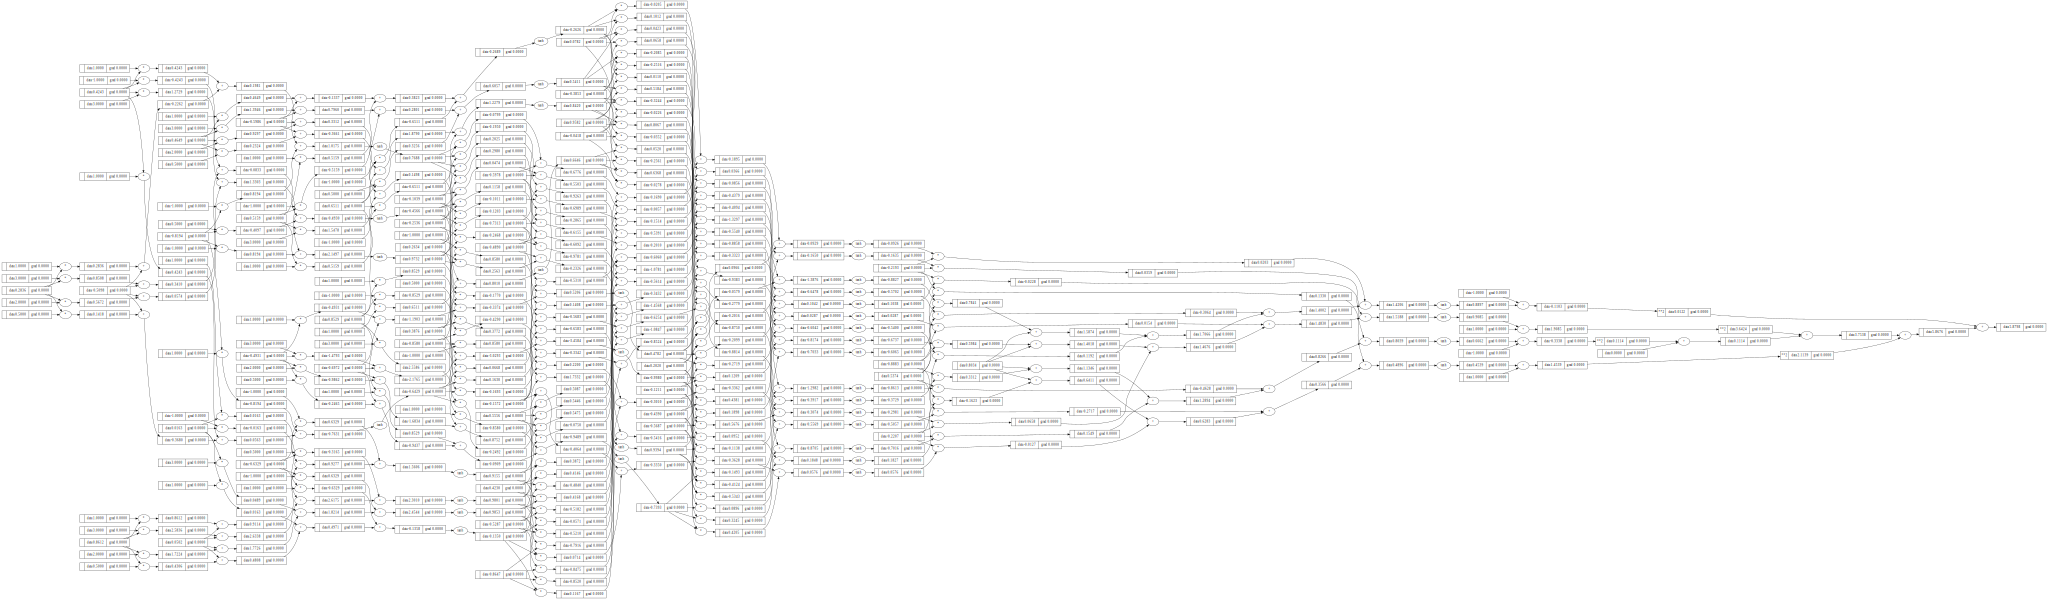

In [99]:
draw_dot(loss)

In [100]:
loss.backward()

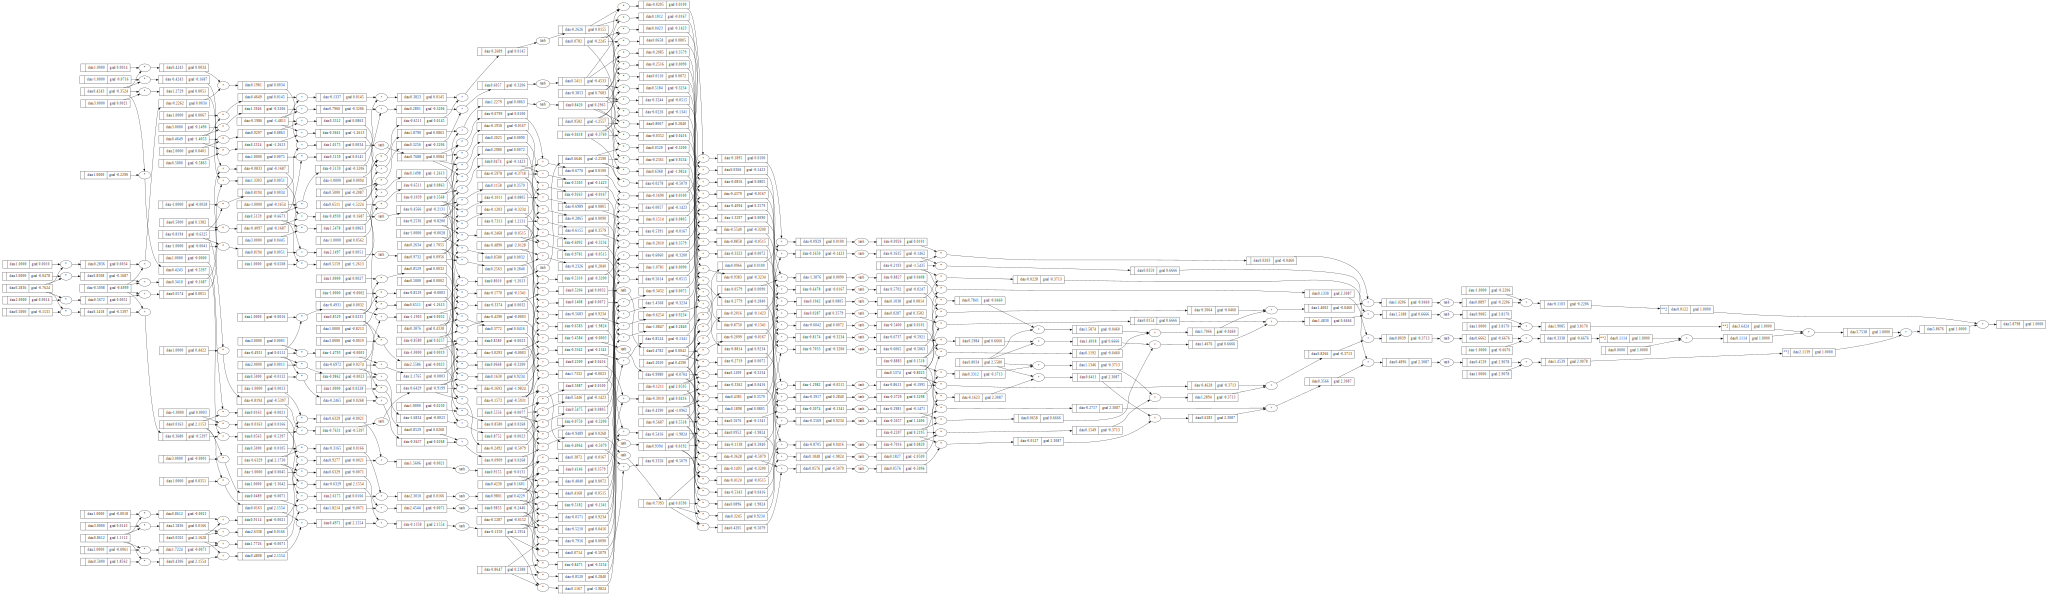

In [101]:
draw_dot(loss)

In [102]:
n.layers[0].neurons[0].w[0].data, n.layers[0].neurons[0].w[0].grad

(0.28359405654932845, -0.762390070555596)

In [103]:
for p in n.params():
    p.data += -0.01 * p.grad

In [124]:
n = MLP(3, [4, 4, 1])
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

In [125]:
from tqdm import trange

In [126]:
losses, accs = [], []

loss -- 0.020537275214982675:  30%|███       | 15/50 [00:00<00:00, 148.48it/s]

loss -- 0.007834970545433261: 100%|██████████| 50/50 [00:00<00:00, 116.73it/s]


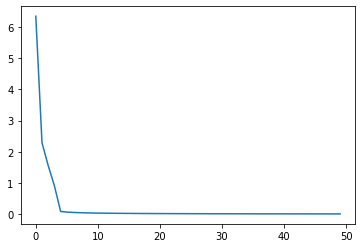

In [127]:
for k in (t:=trange(50)):
    
    # FORWARD PASS
    ypred = [n(x) for x in xs]
    loss = sum((yout - ytrue)**2 for ytrue, yout in zip(ys, ypred))
    losses.append(loss.data)
    
    # BACKWARD PASS
    for p in n.params():
        p.grad = 0.0
    loss.backward()
    
    # UPDATE
    for p in n.params():
        p.data += -0.05 * p.grad
        
    t.set_description(f'loss -- {loss.data}')
    
plt.plot(losses)

In [117]:
loss.data

0.0012719646964615109